# Sales Predictions

* Paul Montecinos
* 5/25/23

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
import sklearn
!python --version

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib, os

## setting random state for reproducibility
## Matplotlib style
fav_style = ('ggplot', 'seaborn-dark-palette')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

Python 3.9.15


C:\Users\paulm\AppData\Local\Temp\ipykernel_1528\3050121446.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(fav_style)


# Load & Clean data

In [2]:
sp =pd.read_csv(r"C:\Users\paulm\Documents\Saved Data for DataFrames - Coding dojo\sales_predictions (1).csv")
sp.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
## make columns lowercase for ease of reference and display names
sp.columns = sp.columns.str.lower()
sp.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales'],
      dtype='object')

In [4]:
# replace_dict1 = {'Medium':1, 'Small':0, 'High':2}
replace_dict2 = {'Tier 1':0, 'Tier 2':1, 'Tier 3':2}
replace_dict4 = {'reg':'Regular', 'low fat':'Low Fat', 'LF':'Low Fat'}
# sp['outlet_size'].replace(replace_dict1, inplace=True)
sp['outlet_location_type'].replace(replace_dict2, inplace=True)
sp['item_fat_content'].replace(replace_dict4, inplace=True)

In [5]:
# reviewing data using .info .isna(missing rows) and .duplicated
print(sp.info(), '\n')
print(sp.isna().sum())
print('\n')
print(sp.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                7060 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   int64  
 8   outlet_size                6113 non-null   object 
 9   outlet_location_type       8523 non-null   int64  
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 799.2+ KB
None 

item_identifier                 0
item

In [6]:
# checking breadown of numeric columns
sp.describe()

,item_weight,item_visibility,item_mrp,outlet_establishment_year,outlet_location_type,item_outlet_sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,1.112871,2181.288914
std,4.643456,0.051598,62.275067,8.371760,0.812757,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,0.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,0.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,2.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,2.000000,13086.964800


In [7]:
sp.describe(exclude='number')

,item_identifier,item_fat_content,item_type,outlet_identifier,outlet_size,outlet_type
count,8523,8523,8523,8523,6113,8523
unique,1559,2,16,10,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Supermarket Type1
freq,10,5517,1232,935,2793,5577


In [8]:
sp = sp.dropna(subset=['item_outlet_sales'])

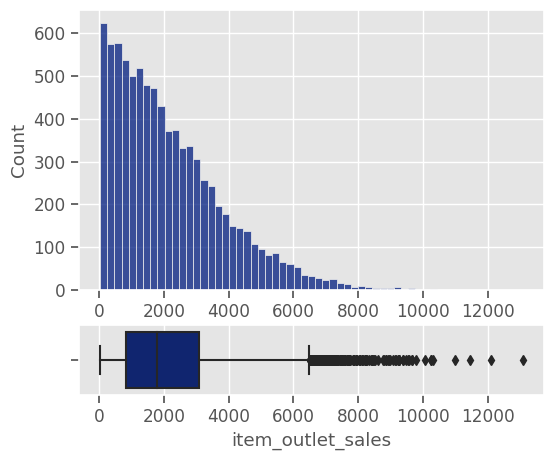

In [9]:
target = 'item_outlet_sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=sp, x=target, ax=axes[0])
sns.boxplot(data=sp, x=target, ax=axes[1]);

# Train, Test, Split

In [10]:
## Make x and y variables
y = sp['item_outlet_sales']
X = sp.drop(columns = ['item_outlet_sales', 'item_identifier',
                       'outlet_establishment_year', 'outlet_identifier'])
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_size,outlet_location_type,outlet_type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,2,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,2,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,0,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,1,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,1,Supermarket Type1


## Preprocessor

In [11]:
# using selector to select all objects
c_sel = make_column_selector(dtype_include='object')
# using selector to select all numbers
n_sel = make_column_selector(dtype_include= 'number')
# creating imputer for nominal features replacing missing vaules with most frequent
freq_imputer = SimpleImputer(strategy = 'most_frequent')
# creating imputer for number features replacing all missing values with median
med_imputer = SimpleImputer(strategy= 'median')
# using standardscaler to scale numerical values
# scaler = StandardScaler()
# using OHE assit in replacing objects for nominal vaules
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
# making pipeline using my med imputer along with scaler
n_pipe = make_pipeline(med_imputer, n_sel)
# making pipeline using my freq imputer with OHE
c_pipe = make_pipeline(freq_imputer, ohe)

In [12]:
preprocessor = make_column_transformer((n_pipe),
                                       (c_pipe, c_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,item_weight,item_visibility,item_mrp,outlet_location_type,item_fat_content_Low Fat,item_fat_content_Regular,item_type_Baking Goods,item_type_Breads,item_type_Breakfast,item_type_Canned,...,item_type_Snack Foods,item_type_Soft Drinks,item_type_Starchy Foods,outlet_size_High,outlet_size_Medium,outlet_size_Small,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
4776,16.350,0.029565,256.4646,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,9.395,0.286345,139.1838,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5191,15.600,0.117575,75.6670,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5390,17.600,0.018944,237.3590,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
860,20.350,0.054363,117.9466,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Function for models and metrics

In [13]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), 
                intercept=False,  intercept_name = 'intercept', 
                annotate=False, ha='left',va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    
    """Plots the top_n coefficients from a Series, with optional annotations.
    Source: https://login.codingdojo.com/m/0/13079/101234"""
    
    if (intercept==False) & ( intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
        
    if top_n==None:
        
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
        
    else:
        
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title  
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
        
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
        
    ## return ax in case want to continue to update/modify figure
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

# code from data-viz-wk17-codealongs-life-expectancy
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    """Source: https://login.codingdojo.com/m/0/13079/101234
    Example Use:
    >> ax = plot_coeffs(coeffs, top_n=15)
    >> annotate_hbars(ax)
    """
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

### Pairplot with regression lines for each feature.

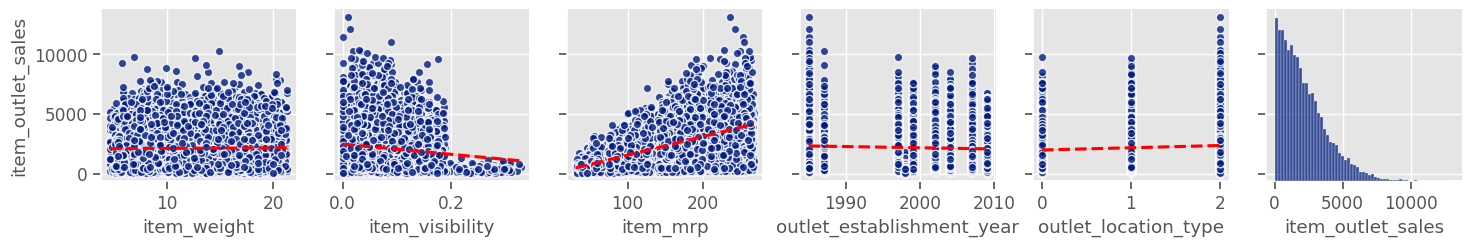

In [14]:
## Making a pairplot with regression lines
sns.pairplot(sp, y_vars='item_outlet_sales',kind='reg',
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));


## Linear Regression Model

In [15]:
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,847.26,"1,140.33"
Test,0.57,805.74,"1,094.72"


### Separating coefficients 

In [16]:
coeffs = get_coefficients(lin_reg)
coeffs

item_weight                          -1.759303
item_visibility                    -424.112615
item_mrp                             15.716569
outlet_location_type                  6.950338
item_fat_content_Low Fat            -31.604456
item_fat_content_Regular             31.604456
item_type_Baking Goods              -17.744663
item_type_Breads                    -47.269332
item_type_Breakfast                  29.806573
item_type_Canned                      8.334461
item_type_Dairy                    -123.871046
item_type_Frozen Foods              -19.787863
item_type_Fruits and Vegetables      26.176538
item_type_Hard Drinks                -5.424049
item_type_Health and Hygiene          9.122574
item_type_Household                 -14.329540
item_type_Meat                      -27.446014
item_type_Others                    -49.609981
item_type_Seafood                   301.070730
item_type_Snack Foods               -38.421118
item_type_Soft Drinks               -59.181105
item_type_Sta

In [17]:
## formatting numbers to not use , thousands sep, and 2 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")
pd.set_option('display.max_rows', None)

In [18]:
coeffs.sort_values()

outlet_type_Grocery Store         -1,740.81
item_visibility                     -424.11
item_type_Dairy                     -123.87
outlet_type_Supermarket Type2        -91.49
item_type_Soft Drinks                -59.18
item_type_Others                     -49.61
item_type_Breads                     -47.27
intercept                            -39.00
item_type_Snack Foods                -38.42
item_fat_content_Low Fat             -31.60
item_type_Meat                       -27.45
item_type_Frozen Foods               -19.79
outlet_size_Medium                   -17.88
item_type_Baking Goods               -17.74
item_type_Household                  -14.33
item_type_Hard Drinks                 -5.42
item_weight                           -1.76
outlet_location_type                   6.95
item_type_Canned                       8.33
outlet_size_Small                      8.60
item_type_Health and Hygiene           9.12
outlet_size_High                       9.28
item_mrp                        

### Plotting Coefficients

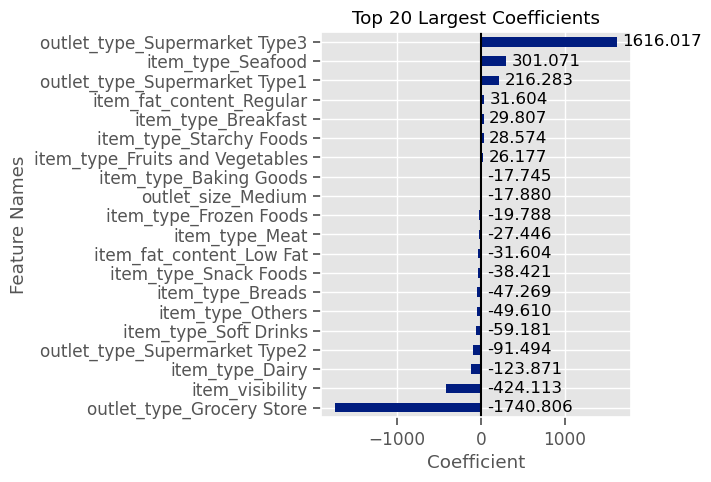

In [19]:
# Plot on graph
plot_coeffs(coeffs,top_n=20,intercept=False,annotate=True);

In [20]:
oi = [c for c in X_train_df.columns if c.startswith('item')]
len(oi)

21

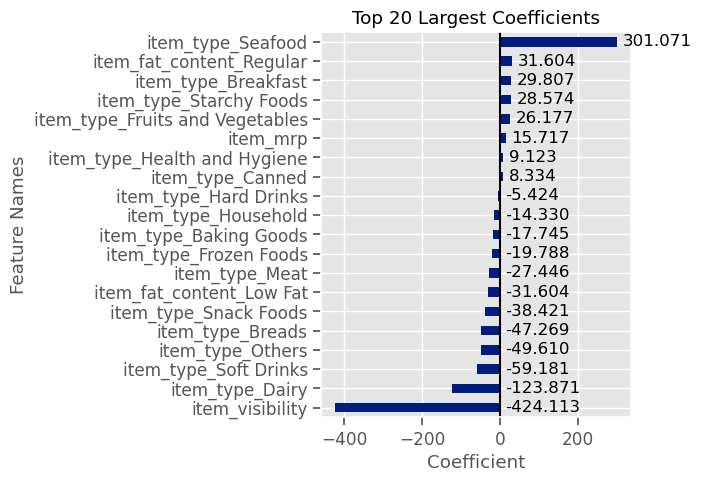

In [21]:
# Plot on graph
plot_coeffs(coeffs[oi],top_n=20,intercept=False,annotate=True);

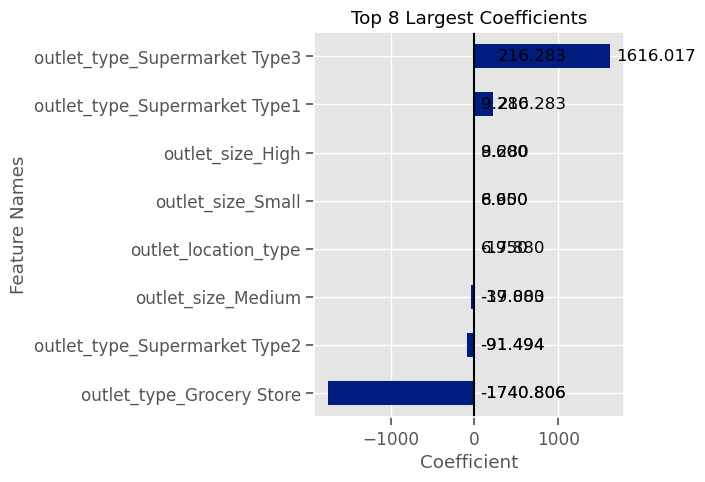

In [22]:
ax = coeffs.drop(oi).sort_values().plot(kind='barh')
# Plot on graph
plot_coeffs(coeffs.drop(oi),top_n=8,intercept=False,annotate=True);

In [23]:
lin_reg_noint= LinearRegression(fit_intercept=False)
lin_reg_noint.fit(X_train_df,y_train)
evaluate_regression(lin_reg_noint, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,847.26,"1,140.33"
Test,0.57,805.74,"1,094.72"


In [24]:
results_linreg = permutation_importance(lin_reg_noint, X_test_df, y_test,
                                       scoring='r2', n_repeats=3,
                                       n_jobs=-1, random_state=47)
results_linreg.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

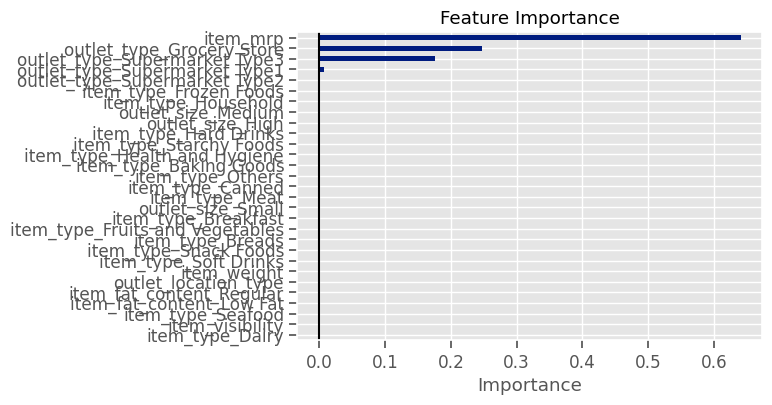

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [25]:
perm_importances_linreg = pd.Series(results_linreg['importances_mean'],
                                   index=lin_reg_noint.feature_names_in_)
plot_importances(perm_importances_linreg)

### Top 3 most impactful features on the Linear Regression Model

* Item MRP 
    - It makes since that the item MRP would have the most importance since it directly affects the amount of revenue a store earns. The higher the prices are correlates to the amount of money the store makes.

* Outlet Type Grocery Store
* Outlet Type Supermarket Type 3

    - The other 2 most impactful features have to do with the outlet type. This shows sales can have positive or negative effects on the sales of a given store type. Certain outlet types may be located in easy to access areas and would typically generate more traffic leading to more sales. Also certain outlet types may have better layouts making it easier to access the things you need quicker.


In [26]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,300.50,432.62
Test,0.54,785.93,"1,130.97"


In [27]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

item_weight                       0.05
item_visibility                   0.11
item_mrp                          0.45
outlet_location_type              0.02
item_fat_content_Low Fat          0.01
item_fat_content_Regular          0.01
item_type_Baking Goods            0.00
item_type_Breads                  0.00
item_type_Breakfast               0.00
item_type_Canned                  0.00
item_type_Dairy                   0.01
item_type_Frozen Foods            0.01
item_type_Fruits and Vegetables   0.01
item_type_Hard Drinks             0.00
item_type_Health and Hygiene      0.00
item_type_Household               0.01
item_type_Meat                    0.00
item_type_Others                  0.00
item_type_Seafood                 0.00
item_type_Snack Foods             0.01
item_type_Soft Drinks             0.01
item_type_Starchy Foods           0.00
outlet_size_High                  0.00
outlet_size_Medium                0.01
outlet_size_Small                 0.01
outlet_type_Grocery Store

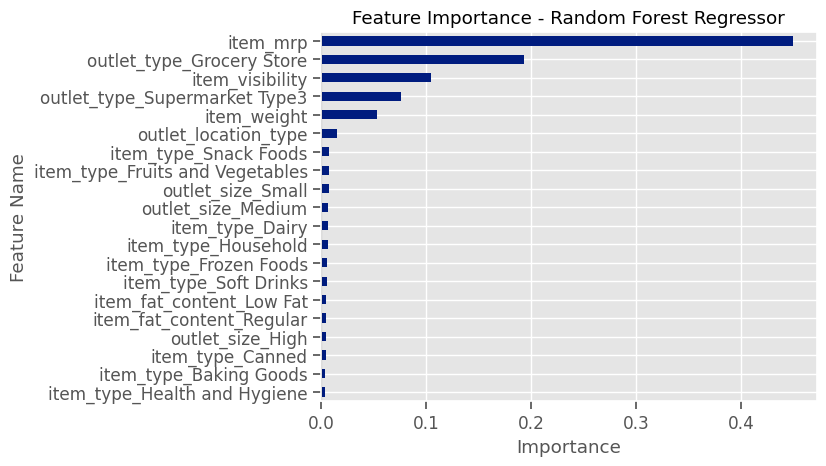

In [28]:
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Regressor',ylabel="Feature Name",
      xlabel='Importance');

### Top 3 most impactful features on the Random Forest model

* Item MRP 
    - As also stated in our Linear Regression model, it makes since that the item MRP would have the most importance since it directly affects the amount of revenue a store earns. The higher the prices are correlates to the amount of money the store makes.

* Outlet Type Grocery Store
    - This shows sales can have positive or negative effects on the sales of a given store type. Certain outlet types may be located in easy to access areas and would typically generate more traffic leading to more sales. Also certain outlet types may have better layouts making it easier to access the things you need quicker.
    
* Item Visibility
    - Speaking of outlet types with better layouts that also brings into question item visibility. Items that are easier to locate within a store would positively generate more sales. Items that are easier to locate would make the store a preference due to convenience of getting in and out of a store. 

In [29]:
result = permutation_importance(rf_reg, X_test_df, y_test, scoring='r2',
                               n_jobs=-1, random_state=42)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [30]:
perm_importances = pd.Series(result['importances_mean'],
                            index=rf_reg.feature_names_in_)
perm_importances

item_weight                       -0.02
item_visibility                   -0.01
item_mrp                           0.70
outlet_location_type              -0.00
item_fat_content_Low Fat          -0.00
item_fat_content_Regular          -0.01
item_type_Baking Goods             0.00
item_type_Breads                  -0.00
item_type_Breakfast               -0.00
item_type_Canned                  -0.00
item_type_Dairy                   -0.01
item_type_Frozen Foods            -0.00
item_type_Fruits and Vegetables   -0.00
item_type_Hard Drinks             -0.00
item_type_Health and Hygiene      -0.00
item_type_Household               -0.00
item_type_Meat                    -0.00
item_type_Others                  -0.00
item_type_Seafood                  0.00
item_type_Snack Foods             -0.00
item_type_Soft Drinks             -0.00
item_type_Starchy Foods           -0.00
outlet_size_High                  -0.00
outlet_size_Medium                -0.00
outlet_size_Small                  0.00


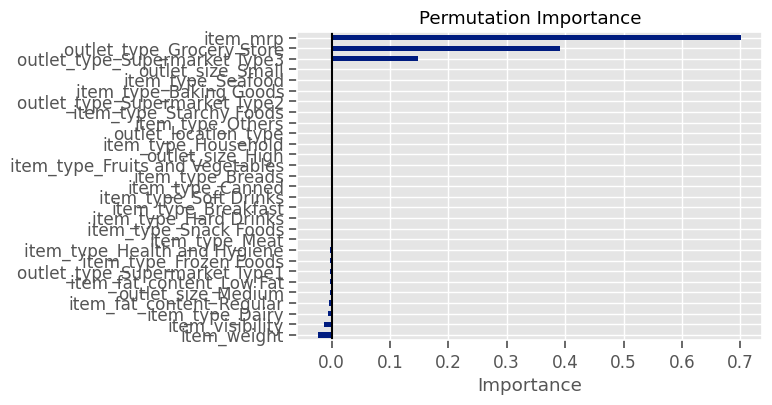

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [31]:
plot_importances(perm_importances, title='Permutation Importance')

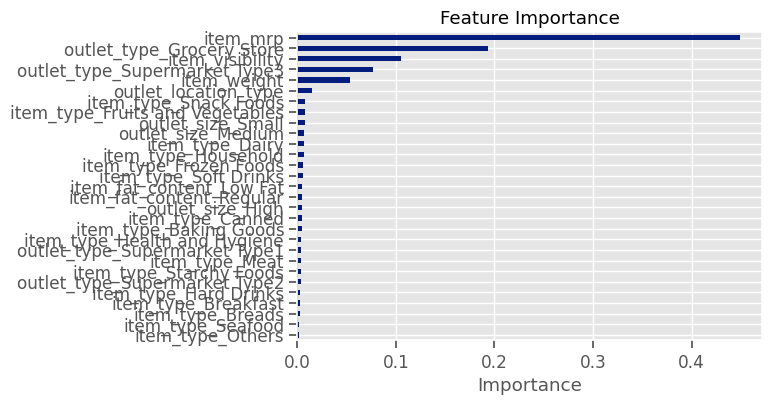

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [32]:
plot_importances(importances)

### Top 5 most important features
* Item MRP
* Outlet Type Grocery Store
* Item Visibility
* Outlet Type Supermarket Type 3
* Item Weight

In [33]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [34]:

folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [35]:
fname = folder+'regression.joblib'
joblib.dump(export, fname)

['Models/regression.joblib']

In [36]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [37]:
# Import and init shap
import shap
shap.initjs()

In [38]:
# Take a sample of the training data
X_shap = shap.sample(X_train_df,nsamples = 500,random_state = 42)
y_shap = y_train.loc[X_shap.index]

# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values form the explainer
shap_values = explainer(X_shap,y_shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


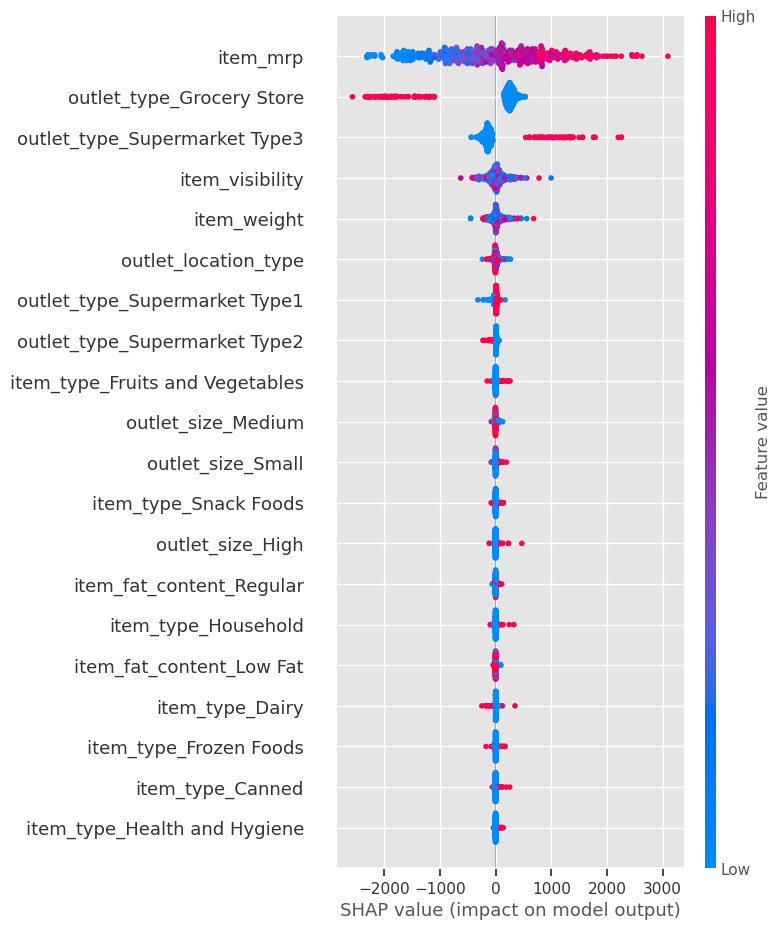

In [39]:
shap.summary_plot(shap_values, features = X_shap)